In [1]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import HuggingFaceAPIDocumentEmbedder

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
documents = [
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome."),
    Document(content="My name is Giorgio and I live in Milan."),
    Document(content="My name is Giorgio and I lived in many cities, but I settled in Naples eventually."),
    Document(content="我的名字叫做蕭中柱，綽號是小柱子，我住在台北市，但有時候我也會去到新北市的住處。")
]

In [3]:
# 創建索引管道
indexing_pipeline = Pipeline()

# 添加組件
# 使用 `HuggingFaceAPIDocumentEmbedder` 為文件 `生成嵌入`
indexing_pipeline.add_component(
    instance=HuggingFaceAPIDocumentEmbedder(
        api_type="serverless_inference_api",
        api_params={
            "model": "sentence-transformers/all-MiniLM-L6-v2"
        }
    ),
    name="doc_embedder"
)

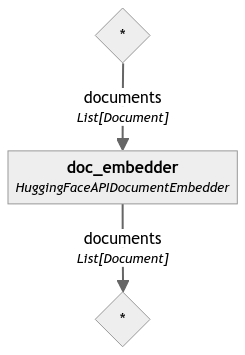

In [4]:
from utils.draw_pipeline import draw_and_display

draw_and_display(indexing_pipeline, "ex16_1_pipe.png")

In [ ]:
# 初始化內存文件儲存
document_store = InMemoryDocumentStore()

In [ ]:
# 添加 DocumentWriter 組件，用於將生成的嵌入寫入內存文件儲存
indexing_pipeline.add_component(
    instance=DocumentWriter(document_store=document_store),
    name="doc_writer"
)

In [ ]:
# 連接組件
indexing_pipeline.connect(
    "doc_embedder.documents", "doc_writer.documents"
)

# 運行索引管道
indexing_pipeline.run(
    {"doc_embedder": {"documents": documents}}
)

In [ ]:
from haystack.components.embedders import HuggingFaceAPITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.generators import HuggingFaceAPIGenerator

In [ ]:
# 定義模板
template = """

根據以下上下文回答問題，僅回答與問題直接相關的內容。

上下文：
{% for document in documents %}
    {{ document.content }}
{% endfor %}

問題：{{ question }}</s>

答案：
"""

In [ ]:
pipe = Pipeline()

In [ ]:
# 添加嵌入生成器
pipe.add_component(
    "embedder",
    HuggingFaceAPITextEmbedder(
        api_type="serverless_inference_api", api_params={"model": "sentence-transformers/all-MiniLM-L6-v2"}
    ),
)

# 添加內存嵌入檢索器
pipe.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(document_store=document_store)
)

# 添加模板生成器
pipe.add_component(
    "prompt_builder",
    PromptBuilder(template=template)
)

# 添加 HuggingFaceAPIGenerator 組件，用於生成答案
pipe.add_component(
    "llm",
    HuggingFaceAPIGenerator(
        api_type="serverless_inference_api",
        api_params={"model": "HuggingFaceH4/zephyr-7b-beta"}
    )
)

# 添加答案建立器
pipe.add_component(
    "answer_builder",
    AnswerBuilder()
)

In [ ]:
pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.connect("llm.replies", "answer_builder.replies")
pipe.connect("llm.meta", "answer_builder.meta")

In [ ]:
draw_and_display(pipe, "ex16_2_pipe.png")

In [ ]:
query = "Where does Mark live?"
pipe.run({
    "embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

In [ ]:
query = "馬克住在哪裡？"
pipe.run({
    "embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

In [ ]:
query = "蕭中柱住在哪裡？"
pipe.run({
    "embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

In [ ]:
query = "小柱有哪些住處？"
pipe.run({
    "embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

In [ ]:
from haystack.components.others import Multiplexer

# 初始化 Multiplexer，指定輸入類型為字串
multiplexer = Multiplexer(str)

In [ ]:
from haystack.components.embedders import HuggingFaceAPITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.generators import HuggingFaceAPIGenerator

In [ ]:
template = """

根據以下上下文回答問題，僅回答與問題直接相關的內容。

上下文：
{% for document in documents %}
    {{ document.content }}
{% endfor %}
問題： {{ question }}</s>

答案：
"""

In [ ]:
# 創建管道
pipe = Pipeline()

In [ ]:
# 添加 Multiplexer 組件
pipe.add_component("multiplexer", multiplexer)

# 添加嵌入生成器
pipe.add_component(
    "embedder",
    HuggingFaceAPITextEmbedder(
        api_type="serverless_inference_api",
        api_params={
            "model": "sentence-transformers/all-MiniLM-L6-v2"
        }
    )
)

# 添加內存嵌入檢索器
pipe.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(document_store=document_store)
)

# 添加模板生成器
pipe.add_component(
    "prompt_builder",
    PromptBuilder(template=template)
)

# 添加 HuggingFaceAPIGenerator 組件，用於生成答案
pipe.add_component(
    "llm",
    HuggingFaceAPIGenerator(
        api_type="serverless_inference_api",
        api_params={"model": "HuggingFaceH4/zephyr-7b-beta"}
    )
)

# 添加答案建立器
pipe.add_component("answer_builder", AnswerBuilder())

In [ ]:
# 將 Multiplexer 連接到所有需要查詢的組件
pipe.connect("multiplexer.value", "embedder.text")
pipe.connect("multiplexer.value", "prompt_builder.question")
pipe.connect("multiplexer.value", "answer_builder.query")

# 連接其餘組件
pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.connect("llm.replies", "answer_builder.replies")
pipe.connect("llm.meta", "answer_builder.meta")

In [ ]:
draw_and_display(pipe, "ex16_3_pipe.png")

In [ ]:
pipe.run({
    "multiplexer": {"value": "小柱有哪些住處？"}
})